## **2. This notebook is for model testing and finding best code and model for Classification model.**

**Importing necessary library**

In [1]:
# basic library
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import concurrent.futures # for faster data fectching
import matplotlib.pyplot as plt

# all the necessary library for the model building and it's evaluations

## evaluation function and objects
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay

## data preprocessing function and objects
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

## model building and algorithms
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings 
warnings.filterwarnings('ignore')


### **2.1 --> fetching data and looking data creating new feature**

#### 2.11 fetching data function

In [2]:
# this function can be used when updating the model and in production model updating
def data_fetch_feature_generation(ticker: str):
    try:
        t = yf.Ticker(ticker)

        # Fetch price history
        df = t.history(interval="1d", period="5y")
        if df.empty:
            print(f"[WARN] No data for {ticker}")
            return None, None, None

        df.index = df.index.strftime("%Y-%m-%d")

        # Technical indicators
        df["return_1d"] = df["Close"].pct_change(1)
        df["return_5d"] = df["Close"].pct_change(5)
        df["return_10d"] = df["Close"].pct_change(10)
        df['rsi'] = ta.momentum.RSIIndicator(df['Close']).rsi()
        df['macd'] = ta.trend.MACD(df['Close']).macd()
        df["stoch"] = ta.momentum.StochasticOscillator(df["High"], df["Low"], df["Close"]).stoch()
        df["roc"] = ta.momentum.ROCIndicator(df["Close"]).roc()
        df["williams_r"] = ta.momentum.WilliamsRIndicator(df["High"], df["Low"], df["Close"]).williams_r()
        df["realized_vol_5"] = df["return_1d"].rolling(5).std()
        df["rolling_std_5"]  = df["Close"].rolling(5).std()
        df["rolling_skew_5"] = df["Close"].rolling(5).skew()
        df["rolling_kurt_5"] = df["Close"].rolling(5).kurt()
        df['sma5'] = df['Close'].rolling(5).mean()
        df['sma10'] = df['Close'].rolling(10).mean()
        df['sma20'] = df['Close'].rolling(20).mean()
        df['sma50'] = df['Close'].rolling(50).mean()
        df['sma100'] = df['Close'].rolling(100).mean()
        df['sma200'] = df['Close'].rolling(200).mean()
        df["obv"] = ta.volume.OnBalanceVolumeIndicator(df["Close"], df["Volume"]).on_balance_volume()
        df["vwap"] = (df["Volume"] * (df["High"]+df["Low"]+df["Close"])/3).cumsum() / df["Volume"].cumsum()
        df["volume_change"] = df["Volume"].pct_change()

        # Safe sector info
        sector = t.info.get('sector', 'Unknown')
        df['sector'] = sector

        # Target (next-day return direction)
        df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

        # Drop missing rows
        df.dropna(inplace=True)

        # Features & labels
        X = df[['return_1d', 'return_5d', 'return_10d', 'stoch', 'roc', 'williams_r', 'realized_vol_5', 'rolling_std_5', 'rolling_skew_5', 'rolling_kurt_5', 'rsi','macd','sma5','Volume', 'sma10','sma20','sma50','sma100','sma200','sector', 'obv', 'vwap', 'volume_change']]
        y = df['target']

        return df, X, y

    except Exception as e:
        print(f"[ERROR] Failed for {ticker}: {e}")
        return None, None, None


#### 2.12 Defining ticker for which data is to be fetched (list of 1000+ ticker)

In [3]:
tickers_ns = [
"20MICRONS.NS","21STCENMGM.NS","360ONE.NS","3IINFOLTD.NS","3MINDIA.NS","3PLAND.NS","5PAISA.NS","63MOONS.NS","A2ZINFRA.NS","AAATECH.NS",
"AADHARHFC.NS","AAKASH.NS","AAREYDRUGS.NS","AARON.NS","AARTECH.NS","AARTIDRUGS.NS","AARTIIND.NS","AARTIPHARM.NS","AARTISURF.NS","AARVEEDEN.NS",
"AARVI.NS","AAVAS.NS","ABAN.NS","ABB.NS","ABBOTINDIA.NS","ABCAPITAL.NS","ABCOTS.NS","ABDL.NS","ABFRL.NS","ABINFRA.NS",
"ABLBL.NS","ABMINTLLTD.NS","ABREL.NS","ABSLAMC.NS","ACC.NS","ACCELYA.NS","ACCURACY.NS","ACE.NS","ACEINTEG.NS","ACI.NS",
"ACL.NS","ACLGATI.NS","ACMESOLAR.NS","ACUTAAS.NS","ADANIENSOL.NS","ADANIENT.NS","ADANIGREEN.NS","ADANIPORTS.NS","ADANIPOWER.NS","ADFFOODS.NS",
"ADL.NS","ADOR.NS","ADROITINFO.NS","ADSL.NS","ADVANIHOTR.NS","ADVENZYMES.NS","AEGISLOG.NS","AEGISVOPAK.NS","AEROENTER.NS","AEROFLEX.NS",
"AERONEU.NS","AETHER.NS","AFCONS.NS","AFFLE.NS","AFFORDABLE.NS","AFIL.NS","AFSL.NS","AGARIND.NS","AGARWALEYE.NS","AGI.NS",
"AGIIL.NS","AGRITECH.NS","AGROPHOS.NS","AGSTRA.NS","AHCL.NS","AHLADA.NS","AHLEAST.NS","AHLUCONT.NS","AIAENG.NS","AIIL.NS",
"AIRAN.NS","AIROLAM.NS","AJANTPHARM.NS","AJAXENGG.NS","AJMERA.NS","AJOONI.NS","AKASH.NS","AKG.NS","AKI.NS","AKSHAR.NS",
"AKSHARCHEM.NS","AKSHOPTFBR.NS","AKUMS.NS","AKZOINDIA.NS","ALANKIT.NS","ALBERTDAVD.NS","ALEMBICLTD.NS","ALICON.NS","ALIVUS.NS","ALKALI.NS",
"ALKEM.NS","ALKYLAMINE.NS","ALLCARGO.NS","ALLDIGI.NS","ALLTIME.NS","ALMONDZ.NS","ALOKINDS.NS","ALPA.NS","ALPHAGEO.NS","ALPSINDUS.NS",
"AMANTA.NS","AMBER.NS","AMBICAAGAR.NS","AMBIKCO.NS","AMBUJACEM.NS","AMDIND.NS","AMJLAND.NS","AMNPLST.NS","AMRUTANJAN.NS","ANANDRATHI.NS",
"ANANTRAJ.NS","ANDHRAPAP.NS","ANDHRSUGAR.NS","ANGELONE.NS","ANIKINDS.NS","ANKITMETAL.NS","ANMOL.NS","ANSALAPI.NS","ANTELOPUS.NS","ANTGRAPHIC.NS",
"ANTHEM.NS","ANUHPHR.NS","ANUP.NS","ANURAS.NS","APARINDS.NS","APCL.NS","APCOTEXIND.NS","APEX.NS","APLAPOLLO.NS","APLLTD.NS",
"APOLLO.NS","APOLLOHOSP.NS","APOLLOPIPE.NS","APOLLOTYRE.NS","APOLSINHOT.NS","APTECHT.NS","APTUS.NS","ARCHIDPLY.NS","ARCHIES.NS","ARE&M.NS",
"ARENTERP.NS","ARFIN.NS","ARIES.NS","ARIHANTCAP.NS","ARIHANTSUP.NS","ARISINFRA.NS","ARKADE.NS","ARMANFIN.NS","AROGRANITE.NS","ARROWGREEN.NS",
"ARSHIYA.NS","ARTEMISMED.NS","ARTNIRMAN.NS","ARVEE.NS","ARVIND.NS","ARVINDFASN.NS","ARVSMART.NS","ASAHIINDIA.NS","ASAHISONG.NS","ASAL.NS",
"ASALCBR.NS","ASHAPURMIN.NS","ASHIANA.NS","ASHIMASYN.NS","ASHOKA.NS","ASHOKAMET.NS","ASHOKLEY.NS","ASIANENE.NS","ASIANHOTNR.NS","ASIANPAINT.NS",
"ASIANTILES.NS","ASKAUTOLTD.NS","ASMS.NS","ASPINWALL.NS","ASTEC.NS","ASTERDM.NS","ASTRAL.NS","ASTRAMICRO.NS","ASTRAZEN.NS","ASTRON.NS",
"ATALREAL.NS","ATAM.NS","ATGL.NS","ATHERENERG.NS","ATL.NS","ATLANTAA.NS","ATLASCYCLE.NS","ATUL.NS","ATULAUTO.NS","AUBANK.NS",
"AURIONPRO.NS","AUROPHARMA.NS","AURUM.NS","AUSOMENT.NS","AUTOAXLES.NS","AUTOIND.NS","AVADHSUGAR.NS","AVALON.NS","AVANTEL.NS","AVANTIFEED.NS",
"AVG.NS","AVL.NS","AVONMORE.NS","AVROIND.NS","AVTNPL.NS","AWFIS.NS","AWHCL.NS","AWL.NS","AXISBANK.NS","AXISCADES.NS",
"AXITA.NS","AYMSYNTEX.NS","AZAD.NS","BAFNAPH.NS","BAGFILMS.NS","BAIDFIN.NS","BAJAJ-AUTO.NS","BAJAJCON.NS","BAJAJELEC.NS","BAJAJFINSV.NS",
"BAJAJHCARE.NS","BAJAJHFL.NS","BAJAJHIND.NS","BAJAJHLDNG.NS","BAJAJINDEF.NS","BAJEL.NS","BAJFINANCE.NS","BALAJEE.NS","BALAJITELE.NS","BALAMINES.NS",
"BALAXI.NS","BALKRISHNA.NS","BALKRISIND.NS","BALMLAWRIE.NS","BALPHARMA.NS","BALRAMCHIN.NS","BALUFORGE.NS","BANARBEADS.NS","BANARISUG.NS","BANCOINDIA.NS",
"BANDHANBNK.NS","BANG.NS","BANKA.NS","BANKBARODA.NS","BANKINDIA.NS","BANSALWIRE.NS","BANSWRAS.NS","BARBEQUE.NS","BASF.NS","BASML.NS",
"BATAINDIA.NS","BAYERCROP.NS","BBL.NS","BBOX.NS","BBTC.NS","BBTCL.NS","BCG.NS","BCLIND.NS","BCONCEPTS.NS","BDL.NS",
"BEARDSELL.NS","BECTORFOOD.NS","BEDMUTHA.NS","BEL.NS","BELLACASA.NS","BELRISE.NS","BEML.NS","BEPL.NS","BERGEPAINT.NS","BESTAGRO.NS"
]
tickers_ns += [
"BFINVEST.NS","BFUTILITIE.NS","BGRENERGY.NS","BHAGCHEM.NS","BHAGERIA.NS","BHAGYANGR.NS","BHANDARI.NS","BHARATFORG.NS","BHARATGEAR.NS","BHARATRAS.NS",
"BHARATSE.NS","BHARATWIRE.NS","BHARTIARTL.NS","BHARTIHEXA.NS","BHEL.NS","BIGBLOC.NS","BIKAJI.NS","BIL.NS","BILVYAPAR.NS","BIOCON.NS",
"BIOFILCHEM.NS","BIRLACABLE.NS","BIRLACORPN.NS","BIRLAMONEY.NS","BIRLANU.NS","BLACKBUCK.NS","BLAL.NS","BLBLIMITED.NS","BLISSGVS.NS","BLKASHYAP.NS",
"BLS.NS","BLSE.NS","BLUECOAST.NS","BLUEDART.NS","BLUEJET.NS","BLUESTARCO.NS","BLUESTONE.NS","BLUSPRING.NS","BODALCHEM.NS","BOHRAIND.NS",
"BOMDYEING.NS","BORANA.NS","BOROLTD.NS","BORORENEW.NS","BOROSCI.NS","BOSCHLTD.NS","BPCL.NS","BPL.NS","BRIGADE.NS","BRIGHOTEL.NS",
"BRITANNIA.NS","BRNL.NS","BROOKS.NS","BSE.NS","BSHSL.NS","BSL.NS","BSOFT.NS","BTML.NS","BUTTERFLY.NS","BVCL.NS",
"BYKE.NS","CALSOFT.NS","CAMLINFINE.NS","CAMPUS.NS","CAMS.NS","CANBK.NS","CANFINHOME.NS","CANTABIL.NS","CAPACITE.NS","CAPITALSFB.NS",
"CAPLIPOINT.NS","CAPTRUST.NS","CARBORUNIV.NS","CARERATING.NS","CARRARO.NS","CARTRADE.NS","CARYSIL.NS","CASTROLIND.NS","CCCL.NS","CCHHL.NS",
"CCL.NS","CDSL.NS","CEATLTD.NS","CEIGALL.NS","CELEBRITY.NS","CELLO.NS","CEMPRO.NS","CENTENKA.NS","CENTEXT.NS","CENTRALBK.NS",
"CENTRUM.NS","CENTUM.NS","CENTURYPLY.NS","CERA.NS","CEREBRAINT.NS","CESC.NS","CEWATER.NS","CGCL.NS","CGPOWER.NS","CHALET.NS",
"CHAMBLFERT.NS","CHEMBOND.NS","CHEMBONDCH.NS","CHEMCON.NS","CHEMFAB.NS","CHEMPLASTS.NS","CHENNPETRO.NS","CHEVIOT.NS","CHOICEIN.NS","CHOLAFIN.NS",
"CHOLAHLDNG.NS","CIEINDIA.NS","CIFL.NS","CIGNITITEC.NS","CINELINE.NS","CINEVISTA.NS","CIPLA.NS","CLEAN.NS","CLEDUCATE.NS","CLSEL.NS",
"CMSINFO.NS","COALINDIA.NS","COASTCORP.NS","COCHINSHIP.NS","COFFEEDAY.NS","COFORGE.NS","COHANCE.NS","COLPAL.NS","COMPINFO.NS","COMPUSOFT.NS",
"COMSYN.NS","CONCOR.NS","CONCORDBIO.NS","CONFIPET.NS","CONSOFINVT.NS","CONTROLPR.NS","CORALFINAC.NS","CORDSCABLE.NS","COROMANDEL.NS","COSMOFIRST.NS",
"COUNCODOS.NS","CPCAP.NS","CPEDU.NS","CPPLUS.NS","CRAFTSMAN.NS","CREATIVE.NS","CREATIVEYE.NS","CREDITACC.NS","CREST.NS","CRISIL.NS",
"CRIZAC.NS","CROMPTON.NS","CROWN.NS","CSBBANK.NS","CSLFINANCE.NS","CTE.NS","CUB.NS","CUBEXTUB.NS","CUMMINSIND.NS","CUPID.NS",
"CURAA.NS","CYBERMEDIA.NS","CYBERTECH.NS","CYIENT.NS","CYIENTDLM.NS","DABUR.NS","DALBHARAT.NS","DALMIASUG.NS","DAMCAPITAL.NS","DAMODARIND.NS",
"DANGEE.NS","DATAMATICS.NS","DATAPATTNS.NS","DAVANGERE.NS","DBCORP.NS","DBEIL.NS","DBL.NS","DBOL.NS","DBREALTY.NS","DBSTOCKBRO.NS",
"DCAL.NS","DCBBANK.NS","DCI.NS","DCM.NS","DCMFINSERV.NS","DCMNVL.NS","DCMSHRIRAM.NS","DCMSRIND.NS","DCW.NS","DCXINDIA.NS",
"DDEVPLSTIK.NS","DECCANCE.NS","DEEDEV.NS","DEEPAKFERT.NS","DEEPAKNTR.NS","DEEPINDS.NS","DELHIVERY.NS","DELPHIFX.NS","DELTACORP.NS","DELTAMAGNT.NS",
"DEN.NS","DENORA.NS","DENTA.NS","DEVIT.NS","DEVX.NS","DEVYANI.NS","DGCONTENT.NS","DHAMPURSUG.NS","DHANBANK.NS","DHANI.NS",
"DHANUKA.NS","DHARAN.NS","DHARMAJ.NS","DHRUV.NS","DHUNINV.NS","DIACABS.NS","DIAMINESQ.NS","DIAMONDYD.NS","DICIND.NS","DIFFNKG.NS",
"DIGIDRIVE.NS","DIGISPICE.NS","DIGITIDE.NS","DIGJAMLMTD.NS","DIL.NS","DISHTV.NS","DIVGIITTS.NS","DIVISLAB.NS","DIXON.NS","DJML.NS",
"DLF.NS","DLINKINDIA.NS","DMART.NS","DMCC.NS","DNAMEDIA.NS","DODLA.NS","DOLATALGO.NS","DOLLAR.NS","DOLPHIN.NS","DOMS.NS",
"DONEAR.NS","DPABHUSHAN.NS","DPSCLTD.NS","DPWIRES.NS","DRCSYSTEMS.NS","DREAMFOLKS.NS","DREDGECORP.NS","DRREDDY.NS","DSSL.NS","DTIL.NS",
"DUCON.NS","DVL.NS","DWARKESH.NS","DYCL.NS","DYNAMATECH.NS","DYNPRO.NS","E2E.NS","EASEMYTRIP.NS","EBGNG.NS","ECLERX.NS",
"ECOSMOBLTY.NS","EDELWEISS.NS","EFCIL.NS","EICHERMOT.NS","EIDPARRY.NS","EIEL.NS","EIFFL.NS","EIHAHOTELS.NS","EIHOTEL.NS","EIMCOELECO.NS",
"EKC.NS","ELDEHSG.NS","ELECON.NS","ELECTCAST.NS","ELECTHERM.NS","ELGIEQUIP.NS","ELGIRUBCO.NS","ELIN.NS","ELLEN.NS","EMAMILTD.NS",
"EMAMIPAP.NS","EMAMIREAL.NS","EMBDL.NS","EMCURE.NS","EMIL.NS","EMKAY.NS","EMMBI.NS","EMSLIMITED.NS","EMUDHRA.NS","ENDURANCE.NS",
"ENERGYDEV.NS","ENGINERSIN.NS","ENIL.NS","ENRIN.NS","ENTERO.NS","EPACK.NS","EPIGRAL.NS","EPL.NS","EQUIPPP.NS","EQUITASBNK.NS"
]
tickers_ns += [
"ERIS.NS","ESABINDIA.NS","ESAFSFB.NS","ESCORTS.NS","ESSARSHPNG.NS","ESSENTIA.NS","ESTER.NS","ETERNAL.NS","ETHOSLTD.NS","EUREKAFORB.NS",
"EUROBOND.NS","EUROPRATIK.NS","EUROTEXIND.NS","EVEREADY.NS","EVERESTIND.NS","EXCEL.NS","EXCELINDUS.NS","EXICOM.NS","EXIDEIND.NS","EXPLEOSOL.NS",
"EXXARO.NS","FACT.NS","FAIRCHEMOR.NS","FAZE3Q.NS","FCL.NS","FCSSOFT.NS","FDC.NS","FEDERALBNK.NS","FEDFINA.NS","FEL.NS",
"FELDVR.NS","FIBERWEB.NS","FIEMIND.NS","FILATEX.NS","FILATFASH.NS","FINCABLES.NS","FINEORG.NS","FINOPB.NS","FINPIPE.NS","FIRSTCRY.NS",
"FISCHER.NS","FIVESTAR.NS","FLAIR.NS","FLEXITUFF.NS","FLFL.NS","FLUOROCHEM.NS","FMGOETZE.NS","FMNL.NS","FOCUS.NS","FOODSIN.NS",
"FORCEMOT.NS","FORTIS.NS","FOSECOIND.NS","FSC.NS","FSL.NS","FUSION.NS","GABRIEL.NS","GAEL.NS","GAIL.NS","GALAPREC.NS",
"GALAXYSURF.NS","GALLANTT.NS","GANDHAR.NS","GANDHITUBE.NS","GANECOS.NS","GANESHBE.NS","GANESHHOU.NS","GANGAFORGE.NS","GANGESSECU.NS","GARFIBRES.NS",
"GARUDA.NS","GATECH.NS","GATECHDVR.NS","GATEWAY.NS","GAYAHWS.NS","GCSL.NS","GEECEE.NS","GEEKAYWIRE.NS","GEMAROMA.NS","GENCON.NS",
"GENESYS.NS","GENUSPAPER.NS","GENUSPOWER.NS","GEOJITFSL.NS","GESHIP.NS","GFLLIMITED.NS","GHCL.NS","GHCLTEXTIL.NS","GICHSGFIN.NS","GICRE.NS",
"GILLANDERS.NS","GILLETTE.NS","GINNIFILA.NS","GIPCL.NS","GKWLIMITED.NS","GLAND.NS","GLAXO.NS","GLENMARK.NS","GLFL.NS","GLOBAL.NS",
"GLOBALE.NS","GLOBALVECT.NS","GLOBE.NS","GLOBECIVIL.NS","GLOBUSSPR.NS","GLOSTERLTD.NS","GMBREW.NS","GMDCLTD.NS","GMMPFAUDLR.NS","GMRAIRPORT.NS",
"GMRP&UI.NS","GNA.NS","GNFC.NS","GOACARBON.NS","GOCLCORP.NS","GOCOLORS.NS","GODAVARIB.NS","GODFRYPHLP.NS","GODHA.NS","GODIGIT.NS",
"GODREJAGRO.NS","GODREJCP.NS","GODREJIND.NS","GODREJPROP.NS","GOENKA.NS","GOKEX.NS","GOKUL.NS","GOKULAGRO.NS","GOLDENTOBC.NS","GOLDIAM.NS",
"GOLDTECH.NS","GOODLUCK.NS","GOPAL.NS","GOYALALUM.NS","GPIL.NS","GPPL.NS","GPTHEALTH.NS","GPTINFRA.NS","GRANULES.NS","GRAPHITE.NS",
"GRASIM.NS","GRAVITA.NS","GREAVESCOT.NS","GREENLAM.NS","GREENPANEL.NS","GREENPLY.NS","GREENPOWER.NS","GRINDWELL.NS","GRINFRA.NS","GRMOVER.NS",
"GROBTEA.NS","GRPLTD.NS","GRSE.NS","GRWRHITECH.NS","GSFC.NS","GSLSU.NS","GSPL.NS","GSS.NS","GTECJAINX.NS","GTL.NS",
"GTLINFRA.NS","GTPL.NS","GUFICBIO.NS","GUJALKALI.NS","GUJAPOLLO.NS","GUJGASLTD.NS","GUJRAFFIA.NS","GUJTHEM.NS","GULFOILLUB.NS","GULFPETRO.NS",
"GULPOLY.NS","GVKPIL.NS","GVPIL.NS","GVPTECH.NS","GVT&D.NS","HAL.NS","HAPPSTMNDS.NS","HAPPYFORGE.NS","HARDWYN.NS","HARIOMPIPE.NS",
"HARRMALAYA.NS","HARSHA.NS","HATHWAY.NS","HATSUN.NS","HAVELLS.NS","HAVISHA.NS","HBLENGINE.NS","HBSL.NS","HCC.NS","HCG.NS",
"HCL-INSYS.NS","HCLTECH.NS","HDBFS.NS","HDFCAMC.NS","HDFCBANK.NS","HDFCLIFE.NS","HDIL.NS","HEADSUP.NS","HECPROJECT.NS","HEG.NS",
"HEIDELBERG.NS","HEMIPROP.NS","HERANBA.NS","HERCULES.NS","HERITGFOOD.NS","HEROMOTOCO.NS","HESTERBIO.NS","HEUBACHIND.NS","HEXATRADEX.NS","HEXT.NS",
"HFCL.NS","HGINFRA.NS","HGM.NS","HGS.NS","HIKAL.NS","HILINFRA.NS","HILTON.NS","HIMATSEIDE.NS","HINDALCO.NS","HINDCOMPOS.NS",
"HINDCON.NS","HINDCOPPER.NS","HINDMOTORS.NS","HINDOILEXP.NS","HINDPETRO.NS","HINDUNILVR.NS","HINDWAREAP.NS","HINDZINC.NS","HIRECT.NS","HISARMETAL.NS",
"HITECH.NS","HITECHCORP.NS","HITECHGEAR.NS","HLEGLAS.NS","HLVLTD.NS","HMAAGRO.NS","HMT.NS","HMVL.NS","HNDFDS.NS","HOMEFIRST.NS",
"HONASA.NS","HONAUT.NS","HONDAPOWER.NS","HPAL.NS","HPIL.NS","HPL.NS","HSCL.NS","HTMEDIA.NS","HUBTOWN.NS","HUDCO.NS",
"HUHTAMAKI.NS","HYBRIDFIN.NS","HYUNDAI.NS","ICDSLTD.NS","ICEMAKE.NS","ICICIBANK.NS","ICICIGI.NS","ICICIPRULI.NS","ICIL.NS","ICRA.NS",
"IDBI.NS","IDEA.NS","IDEAFORGE.NS","IDFCFIRSTB.NS","IEL.NS","IEX.NS","IFBAGRO.NS","IFBIND.NS","IFCI.NS","IFGLEXPOR.NS"
]
tickers_ns += [
"IGARASHI.NS","IGCL.NS","IGIL.NS","IGL.NS","IGPL.NS","IIFL.NS","IIFLCAPS.NS","IITL.NS","IKIO.NS","IKS.NS",
"IL&FSENGG.NS","IL&FSTRANS.NS","IMAGICAA.NS","IMFA.NS","IMPAL.NS","IMPEXFERRO.NS","INCREDIBLE.NS","INDBANK.NS","INDGN.NS","INDHOTEL.NS",
"INDIACEM.NS","INDIAGLYCO.NS","INDIAMART.NS","INDIANB.NS","INDIANCARD.NS","INDIANHUME.NS","INDIASHLTR.NS","INDIGO.NS","INDIGOPNTS.NS","INDIQUBE.NS",
"INDNIPPON.NS","INDOAMIN.NS","INDOBORAX.NS","INDOCO.NS","INDOFARM.NS","INDORAMA.NS","INDOSTAR.NS","INDOTECH.NS","INDOTHAI.NS","INDOUS.NS",
"INDOWIND.NS","INDRAMEDCO.NS","INDSWFTLAB.NS","INDTERRAIN.NS","INDUSINDBK.NS","INDUSTOWER.NS","INFIBEAM.NS","INFOBEAN.NS","INFOMEDIA.NS","INFY.NS",
"INGERRAND.NS","INNOVACAP.NS","INNOVANA.NS","INOXGREEN.NS","INOXINDIA.NS","INOXWIND.NS","INSECTICID.NS","INSPIRISYS.NS","INTELLECT.NS","INTENTECH.NS",
"INTERARCH.NS","INTLCONV.NS","INVENTURE.NS","IOB.NS","IOC.NS","IOLCP.NS","IONEXCHANG.NS","IPCALAB.NS","IPL.NS","IRB.NS",
"IRCON.NS","IRCTC.NS","IREDA.NS","IRFC.NS","IRIS.NS","IRISDOREME.NS","IRMENERGY.NS","ISFT.NS","ISGEC.NS","ISHANCH.NS",
"ITC.NS","ITCHOTELS.NS","ITDC.NS","ITI.NS","IVC.NS","IVP.NS","IXIGO.NS","IZMO.NS","J&KBANK.NS","JAGRAN.NS",
"JAGSNPHARM.NS","JAIBALAJI.NS","JAICORPLTD.NS","JAIPURKURT.NS","JAMNAAUTO.NS","JASH.NS","JAYAGROGN.NS","JAYBARMARU.NS","JAYNECOIND.NS","JAYSREETEA.NS",
"JBCHEPHARM.NS","JBMA.NS","JCHAC.NS","JETFREIGHT.NS","JGCHEM.NS","JHS.NS","JINDALPHOT.NS","JINDALPOLY.NS","JINDALSAW.NS","JINDALSTEL.NS",
"JINDRILL.NS","JINDWORLD.NS","JIOFIN.NS","JISLDVREQS.NS","JISLJALEQS.NS","JITFINFRA.NS","JKCEMENT.NS","JKIL.NS","JKLAKSHMI.NS","JKPAPER.NS",
"JKTYRE.NS","JLHL.NS","JMA.NS","JMFINANCIL.NS","JNKINDIA.NS","JOCIL.NS","JPOLYINVST.NS","JPPOWER.NS","JSFB.NS","JSL.NS",
"JSLL.NS","JSWCEMENT.NS","JSWENERGY.NS","JSWHL.NS","JSWINFRA.NS","JSWSTEEL.NS","JTEKTINDIA.NS","JTLIND.NS","JUBLCPL.NS","JUBLFOOD.NS",
"JUBLINGREA.NS","JUBLPHARMA.NS","JUNIPER.NS","JUSTDIAL.NS","JWL.NS","JYOTHYLAB.NS","JYOTICNC.NS","JYOTISTRUC.NS","KABRAEXTRU.NS","KAJARIACER.NS",
"KAKATCEM.NS","KALAMANDIR.NS","KALPATARU.NS","KALYANI.NS","KALYANIFRG.NS","KALYANKJIL.NS","KAMATHOTEL.NS","KAMDHENU.NS","KAMOPAINTS.NS","KANANIIND.NS",
"KANORICHEM.NS","KANPRPLA.NS","KANSAINER.NS","KAPSTON.NS","KARMAENG.NS","KARURVYSYA.NS","KAUSHALYA.NS","KAVDEFENCE.NS","KAYA.NS","KAYNES.NS",
"KCP.NS","KCPSUGIND.NS","KDDL.NS","KEC.NS","KECL.NS","KEEPLEARN.NS","KEI.NS","KELLTONTEC.NS","KERNEX.NS","KESORAMIND.NS",
"KEYFINSERV.NS","KFINTECH.NS","KHADIM.NS","KHAICHEM.NS","KHAITANLTD.NS","KHANDSE.NS","KICL.NS","KILITCH.NS","KIMS.NS","KINGFA.NS",
"KIOCL.NS","KIRIINDUS.NS","KIRLOSBROS.NS","KIRLOSENG.NS","KIRLOSIND.NS","KIRLPNU.NS","KITEX.NS","KKCL.NS","KMEW.NS","KMSUGAR.NS",
"KNRCON.NS","KOHINOOR.NS","KOKUYOCMLN.NS","KOLTEPATIL.NS","KOPRAN.NS","KOTAKBANK.NS","KOTARISUG.NS","KOTHARIPET.NS","KOTHARIPRO.NS","KPEL.NS",
"KPIGREEN.NS","KPIL.NS","KPITTECH.NS","KPRMILL.NS","KRBL.NS","KREBSBIO.NS","KRIDHANINF.NS","KRISHANA.NS","KRISHIVAL.NS","KRITI.NS",
"KRITIKA.NS","KRITINUT.NS","KRN.NS","KRONOX.NS","KROSS.NS","KRSNAA.NS","KRYSTAL.NS","KSB.NS","KSCL.NS","KSHITIJPOL.NS",
"KSL.NS","KSOLVES.NS","KTKBANK.NS","KUANTUM.NS","LAGNAM.NS","LAL.NS","LALPATHLAB.NS","LAMBODHARA.NS","LANCORHOL.NS","LANDMARK.NS",
"LAOPALA.NS","LASA.NS","LATENTVIEW.NS","LATTEYS.NS","LAURUSLABS.NS","LAXMICOT.NS","LAXMIDENTL.NS","LAXMIINDIA.NS","LCCINFOTEC.NS","LEMONTREE.NS",
"LEXUS.NS","LFIC.NS","LGBBROSLTD.NS","LGHL.NS","LIBAS.NS","LIBERTSHOE.NS","LICHSGFIN.NS","LICI.NS","LIKHITHA.NS","LINC.NS",
"LINCOLN.NS","LINDEINDIA.NS","LLOYDSENGG.NS","LLOYDSENT.NS","LLOYDSME.NS","LMW.NS","LODH...","ZUARIIND.NS","ZYDUSLIFE.NS","ZYDUSWELL.NS"
]


#### 2.13 simple for loop to fetch data for all the tickers

In [4]:
main_base_df_list = []
X_list = []
y_list = []

# Worker wrapper for safe execution
def safe_fetch(ticker):
    try:
        return data_fetch_feature_generation(ticker)
    except Exception as e:
        print(f"[ERROR] {ticker}: {e}")
        return None, None, None

# Run in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    results = list(executor.map(safe_fetch, tickers_ns))

# Collect results
for i, (df_fetch, X_fetch, y_fetch) in enumerate(results, start=1):
    if df_fetch is None or X_fetch is None or y_fetch is None:
        print(f"{i}/{len(tickers_ns)} skipped")
        continue
    main_base_df_list.append(df_fetch)
    X_list.append(X_fetch)
    y_list.append(y_fetch)
    print(f"{i}/{len(tickers_ns)} done")

# Concatenate once
main_base_df = pd.concat(main_base_df_list, axis=0).reset_index(drop=True)
X = pd.concat(X_list, axis=0).reset_index(drop=True)
y = pd.concat(y_list, axis=0).reset_index(drop=True)


[ERROR] Failed for LODH...: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for LFIC.NS: Too Many Requests. Rate limited. Try after a while.


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}


[ERROR] Failed for LIKHITHA.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for LINCOLN.NS: argument of type 'NoneType' is not iterable


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}


[ERROR] Failed for LINC.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for ZUARIIND.NS: Too Many Requests. Rate limited. Try after a while.


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}
HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}


[ERROR] Failed for LINDEINDIA.NS: Too Many Requests. Rate limited. Try after a while.
[ERROR] Failed for LLOYDSME.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for LGBBROSLTD.NS: Too Many Requests. Rate limited. Try after a while.


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"User is unable to access this feature - https://bit.ly/yahoo-finance-api-feedback"}}}


[ERROR] Failed for ZYDUSLIFE.NS: argument of type 'NoneType' is not iterable
[ERROR] Failed for ZYDUSWELL.NS: Too Many Requests. Rate limited. Try after a while.


HTTP Error 401: {"finance":{"result":null,"error":{"code":"Unauthorized","description":"Invalid Crumb"}}}


[ERROR] Failed for LMW.NS: Too Many Requests. Rate limited. Try after a while.
1/1120 done
2/1120 done
3/1120 done
4/1120 done
5/1120 done
6/1120 done
7/1120 done
8/1120 done
9/1120 done
10/1120 done
11/1120 done
12/1120 done
13/1120 done
14/1120 done
15/1120 done
16/1120 done
17/1120 done
18/1120 done
19/1120 done
20/1120 done
21/1120 done
22/1120 done
23/1120 done
24/1120 done
25/1120 done
26/1120 done
27/1120 done
28/1120 done
29/1120 done
30/1120 done
31/1120 done
32/1120 done
33/1120 done
34/1120 done
35/1120 done
36/1120 done
37/1120 done
38/1120 done
39/1120 done
40/1120 done
41/1120 done
42/1120 done
43/1120 done
44/1120 done
45/1120 done
46/1120 done
47/1120 done
48/1120 done
49/1120 done
50/1120 done
51/1120 done
52/1120 done
53/1120 done
54/1120 done
55/1120 done
56/1120 done
57/1120 done
58/1120 done
59/1120 done
60/1120 done
61/1120 done
62/1120 done
63/1120 done
64/1120 done
65/1120 done
66/1120 done
67/1120 done
68/1120 done
69/1120 done
70/1120 done
71/1120 done
72/1120

#### Summary for above code cells
* We first made a function that fetchs stock historical prices of stocks and creats more features.
* The we difined a list containing 1000+ tickers listed on NSE.
* THe using for loop and concurrent tool which fetchs all the data.

### **2.2 --> Model building for best to find algorithms**

#### 2.21 Segregating feature as num and cat

In [5]:
cat_cols = []
num_cols = []
for i in X.columns:
    if X[i].dtype == "O":
        cat_cols.append(i)
    else:
        num_cols.append(i)
print("Categorical Features : ", cat_cols)
print("Numerical Features : ", num_cols)

Categorical Features :  ['sector']
Numerical Features :  ['return_1d', 'return_5d', 'return_10d', 'stoch', 'roc', 'williams_r', 'realized_vol_5', 'rolling_std_5', 'rolling_skew_5', 'rolling_kurt_5', 'rsi', 'macd', 'sma5', 'Volume', 'sma10', 'sma20', 'sma50', 'sma100', 'sma200', 'obv', 'vwap', 'volume_change']


#### Feature Summary

- **Categorical Features**  
  - `sector`: Represents the industry/sector classification of the stock.  

- **Numerical Features**  
  - `return_1d`: Daily return of the stock.  
  - `return_5d`: Return over the last 5 days.  
  - `return_10d`: Return over the last 10 days.  
  - `stoch`: Stochastic oscillator value, measures momentum.  
  - `roc`: Rate of Change, shows percentage change over a period.  
  - `williams_r`: Williams %R, momentum indicator for overbought/oversold conditions.  
  - `realized_vol_5`: Realized volatility over the last 5 days.  
  - `rolling_std_5`: Rolling standard deviation (5-day window).  
  - `rolling_skew_5`: Rolling skewness (5-day window).  
  - `rolling_kurt_5`: Rolling kurtosis (5-day window).  
  - `rsi`: Relative Strength Index, momentum-based indicator.  
  - `macd`: Moving Average Convergence Divergence, trend/momentum indicator.  
  - `sma5`: Simple Moving Average (5-day).  
  - `Volume`: Trading volume of the stock.  
  - `sma10`: Simple Moving Average (10-day).  
  - `sma20`: Simple Moving Average (20-day).  
  - `sma50`: Simple Moving Average (50-day).  
  - `sma100`: Simple Moving Average (100-day).  
  - `sma200`: Simple Moving Average (200-day).  
  - `obv`: On-Balance Volume, combines price and volume for trend signals.  
  - `vwap`: Volume Weighted Average Price.  
  - `volume_change`: Change in trading volume compared to previous periods.  


#### 2.22 building models without hyperparameter tuning

In [6]:
def train_and_evaluate_models(X, y, num_cols, cat_cols, test_size=0.2, random_state=42):
    """
    Train multiple classification models with preprocessing pipeline
    and print accuracy + classification report for each.
    """
    # Numeric columns
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.dropna()   # drop rows where any feature is NaN (was inf before)

    # Also align y with X (important!)
    y = y.loc[X.index]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
        ]
    )

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000),
        "DecisionTreeClassifier": DecisionTreeClassifier(),
        "GaussianNB": GaussianNB(),
        "AdaBoostClassifier": AdaBoostClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=random_state),
        "LightGBM": LGBMClassifier(random_state=random_state),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state)
    }

    # Train & evaluate
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        print(f"\n====== {name} ======")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))


#### Function Summary: `train_and_evaluate_models`

- **Purpose**  
  - Trains multiple classification models on given dataset.  
  - Handles preprocessing for numerical and categorical features.  
  - Evaluates models using accuracy and classification report.  

- **Preprocessing Steps**  
  - Replace infinite values (`inf`, `-inf`) with NaN.  
  - Drop rows with missing values.  
  - Align target `y` with filtered features `X`.  
  - Split data into train and test sets (stratified).  
  - Scale numerical features using `StandardScaler`.  
  - Encode categorical features using `OrdinalEncoder` with unknown handling.  

- **Models Trained**  
  - Logistic Regression  
  - Decision Tree Classifier  
  - Gaussian Naive Bayes  
  - AdaBoost Classifier  
  - XGBoost Classifier  
  - LightGBM Classifier  
  - CatBoost Classifier  

- **Evaluation Output**  
  - For each model, prints:  
    - Model name  
    - Accuracy score on test data  
    - Detailed classification report (precision, recall, F1-score, support)  


In [7]:
train_and_evaluate_models(X, y, num_cols, cat_cols) # trigger the function


====== Logistic Regression ======
Accuracy: 0.533659151820905
              precision    recall  f1-score   support

           0       0.53      0.98      0.69     98205
           1       0.50      0.02      0.04     85742

    accuracy                           0.53    183947
   macro avg       0.51      0.50      0.37    183947
weighted avg       0.52      0.53      0.39    183947


====== DecisionTreeClassifier ======
Accuracy: 0.5172250702648046
              precision    recall  f1-score   support

           0       0.55      0.54      0.55     98205
           1       0.48      0.49      0.48     85742

    accuracy                           0.52    183947
   macro avg       0.52      0.52      0.52    183947
weighted avg       0.52      0.52      0.52    183947


====== GaussianNB ======
Accuracy: 0.4699723289860666
              precision    recall  f1-score   support

           0       0.51      0.19      0.28     98205
           1       0.46      0.79      0.58     8574

#### Model Evaluation Summary

- **Logistic Regression**
  - Accuracy: **0.53**
  - Class 0: High recall (0.98), but Class 1 recall is very poor (0.02).
  - Imbalanced performance, favors majority class.

- **Decision Tree Classifier**
  - Accuracy: **0.52**
  - Balanced precision/recall for both classes (~0.5).
  - No strong advantage over baseline.

- **Gaussian Naive Bayes**
  - Accuracy: **0.47**
  - Class 1 recall is decent (0.79), but Class 0 recall is very poor (0.19).
  - Produces unbalanced predictions.

- **AdaBoost Classifier**
  - Accuracy: **0.54**
  - Good recall for Class 0 (0.94), but weak recall for Class 1 (0.09).
  - Skews toward majority class.

- **XGBoost**
  - Accuracy: **0.56**
  - Better balance: Class 0 recall (0.80), Class 1 recall (0.28).
  - Improved overall f1-scores compared to simpler models.

- **LightGBM**
  - Accuracy: **0.56**
  - Strong Class 0 recall (0.87), weak Class 1 recall (0.21).
  - Skewed toward negative class but slightly better than AdaBoost.

- **CatBoost**
  - Accuracy: **0.56**
  - Class 0 recall (0.78), Class 1 recall (0.31).
  - More balanced than LightGBM and AdaBoost.

---

**Overall Insights**  
- Tree-based boosting models (**XGBoost, LightGBM, CatBoost**) perform best (~0.56 accuracy).  
- Simpler models (**Logistic Regression, Decision Tree, GaussianNB**) show weaker balance between classes.  
- Class imbalance is a major issue — models tend to favor Class 0 heavily.  

### **2.3 --> Hyper Tuning the Model will be very expensive so we will try stacking for best Model.**

#### 2.31 Splitting data in training and test data and handling nan values.

In [10]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()   # drop rows where any feature is NaN (was inf before)

# Also align y with X (important!)
y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 2.32 We will be Stacking CatBosst, LightGBM and XGBoost. 

In [9]:
def stack_models(X, y, num_cols, cat_cols, test_size=0.2, random_state=42):

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
        ]
    )

    # Base models
    base_models = [
        ("xgb", XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=random_state)),
        ("lgbm", LGBMClassifier(random_state=random_state)),
        ("cat", CatBoostClassifier(verbose=0, random_state=random_state))
    ]

    # Meta-model
    meta_model = LogisticRegression(max_iter=2000)

    # Stacking Classifier
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("stack", StackingClassifier(
            estimators=base_models,
            final_estimator=meta_model,
            cv=5
        ))
    ])

    # Fit and predict
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Stacked Model Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return clf

stacking_clf = stack_models(X,y, num_cols, cat_cols)

[LightGBM] [Info] Number of positive: 342965, number of negative: 392820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5623
[LightGBM] [Info] Number of data points in the train set: 735785, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466121 -> initscore=-0.135723
[LightGBM] [Info] Start training from score -0.135723
[LightGBM] [Info] Number of positive: 274372, number of negative: 314256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5623
[LightGBM] [Info] Number of data points in the train set: 588628, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.466121 -> initscore=-0.135723
[LightGBM] [Info] Start training from score -0.135723
[Light

#### Stacked Model Evaluation Summary

- **Accuracy:** 0.56  
- **Class 0 (Majority Class):**
  - Precision: 0.56  
  - Recall: 0.80 (good at detecting Class 0)  
  - F1-score: 0.66  

- **Class 1 (Minority Class):**
  - Precision: 0.56  
  - Recall: 0.29 (poor detection of Class 1)  
  - F1-score: 0.38  

- **Overall Performance:**
  - Macro Avg F1: 0.52 → balanced but modest performance.  
  - Weighted Avg F1: 0.53 → slightly favors majority class.  
  - Stacking improves stability but class imbalance remains an issue.  


#### 2.33 We have got 0.56 accuracy we will try modified y_pred_proba to improve accuracy mode

ROC-AUC: 0.5829
Best Threshold: 0.4700
Accuracy: 0.5577856665235095
F1 Score: 0.5180585837520144


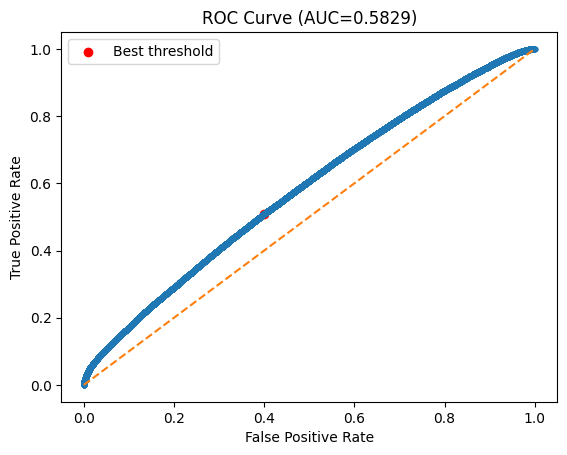

In [11]:
# Get predicted probabilities
y_proba = stacking_clf.predict_proba(X_test)[:, 1]  # prob for class=1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Find best cutoff (Youden’s J statistic = maximize TPR - FPR)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Best Threshold: {best_thresh:.4f}")

# Apply threshold
y_pred_opt = (y_proba >= best_thresh).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("F1 Score:", f1_score(y_test, y_pred_opt))

# Plot ROC curve
plt.plot(fpr, tpr, marker='.')
plt.plot([0,1],[0,1],'--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label="Best threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={roc_auc:.4f})")
plt.legend()
plt.show()

In [14]:
def predict_with_threshold(model, X_test, y_test, threshold=best_thresh):
    # Get probabilities for class 1
    proba = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = np.where(proba >= threshold, 1, 0)

    # Metrics
    print(f"Threshold = {threshold}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


predict_with_threshold(stacking_clf, X_test, y_test)

Threshold = 0.47003292471115604
Accuracy: 0.5577856665235095
              precision    recall  f1-score   support

           0       0.58      0.60      0.59     98205
           1       0.53      0.51      0.52     85742

    accuracy                           0.56    183947
   macro avg       0.56      0.55      0.55    183947
weighted avg       0.56      0.56      0.56    183947



#### precision is low for class 1, lets try to achive above 0.6 with recall of +0.4

In [16]:
# Generate values from 0.40 up to (but not including) 0.61, with a step of 0.2
thresholds_values = np.arange(0.40, 0.60, 0.02)

for thres in thresholds_values:
    predict_with_threshold(stacking_clf, X_test, y_test, threshold=thres)

Threshold = 0.4
Accuracy: 0.5086519486591247
              precision    recall  f1-score   support

           0       0.66      0.17      0.26     98205
           1       0.49      0.90      0.63     85742

    accuracy                           0.51    183947
   macro avg       0.57      0.53      0.45    183947
weighted avg       0.58      0.51      0.44    183947

Threshold = 0.42000000000000004
Accuracy: 0.5215415309844683
              precision    recall  f1-score   support

           0       0.64      0.24      0.35     98205
           1       0.49      0.84      0.62     85742

    accuracy                           0.52    183947
   macro avg       0.56      0.54      0.49    183947
weighted avg       0.57      0.52      0.48    183947

Threshold = 0.44000000000000006
Accuracy: 0.536627398109238
              precision    recall  f1-score   support

           0       0.61      0.36      0.45     98205
           1       0.50      0.74      0.60     85742

    accuracy    

#### Threshold Tuning Summary

- **Threshold = 0.40**
  - Accuracy: 0.51  
  - Class 0 → Precision: 0.66, Recall: 0.17, F1: 0.26  
  - Class 1 → Precision: 0.49, Recall: 0.90, F1: 0.63  
  - Model favors Class 1 (positive detection).

- **Threshold = 0.42**
  - Accuracy: 0.52  
  - Class 0 → Precision: 0.64, Recall: 0.24, F1: 0.35  
  - Class 1 → Precision: 0.49, Recall: 0.84, F1: 0.62  
  - Slightly more balanced, still biased toward Class 1.

- **Threshold = 0.44**
  - Accuracy: 0.54  
  - Class 0 → Precision: 0.61, Recall: 0.36, F1: 0.45  
  - Class 1 → Precision: 0.50, Recall: 0.74, F1: 0.60  
  - Better trade-off, classes closer in recall.

- **Threshold = 0.46**
  - Accuracy: 0.55  
  - Class 0 → Precision: 0.59, Recall: 0.52, F1: 0.55  
  - Class 1 → Precision: 0.52, Recall: 0.59, F1: 0.55  
  - Balanced detection across both classes.

- **Threshold = 0.48**
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.58, Recall: 0.68, F1: 0.62  
  - Class 1 → Precision: 0.54, Recall: 0.43, F1: 0.48  
  - Slightly favors Class 0.

- **Threshold = 0.50 (Default)**  
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.56, Recall: 0.80, F1: 0.66  
  - Class 1 → Precision: 0.56, Recall: 0.29, F1: 0.38  
  - Strong skew toward Class 0 detection.

- **Threshold = 0.52**
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.56, Recall: 0.89, F1: 0.68  
  - Class 1 → Precision: 0.59, Recall: 0.19, F1: 0.29  
  - Heavy bias toward Class 0.

- **Threshold = 0.54**
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.55, Recall: 0.93, F1: 0.69  
  - Class 1 → Precision: 0.63, Recall: 0.13, F1: 0.22  
  - Over-detects Class 0.

- **Threshold = 0.56**
  - Accuracy: 0.56  
  - Class 0 → Precision: 0.55, Recall: 0.95, F1: 0.70  
  - Class 1 → Precision: 0.66, Recall: 0.10, F1: 0.18  
  - Severe imbalance toward Class 0.

- **Threshold = 0.58**
  - Accuracy: 0.55  
  - Class 0 → Precision: 0.55, Recall: 0.97, F1: 0.70  
  - Class 1 → Precision: 0.69, Recall: 0.08, F1: 0.15  
  - Extreme skew toward Class 0.

---

#### Precision / Recall Matrix by Threshold

| Threshold | Accuracy | Class 0 Precision | Class 0 Recall | Class 1 Precision | Class 1 Recall |
|-----------|----------|-------------------|----------------|-------------------|----------------|
| 0.40      | 0.51     | 0.66              | 0.17           | 0.49              | 0.90           |
| 0.42      | 0.52     | 0.64              | 0.24           | 0.49              | 0.84           |
| 0.44      | 0.54     | 0.61              | 0.36           | 0.50              | 0.74           |
| 0.46      | 0.55     | 0.59              | 0.52           | 0.52              | 0.59           |
| 0.48      | 0.56     | 0.58              | 0.68           | 0.54              | 0.43           |
| 0.50      | 0.56     | 0.56              | 0.80           | 0.56              | 0.29           |
| 0.52      | 0.56     | 0.56              | 0.89           | 0.59              | 0.19           |
| 0.54      | 0.56     | 0.55              | 0.93           | 0.63              | 0.13           |
| 0.56      | 0.56     | 0.55              | 0.95           | 0.66              | 0.10           |
| 0.58      | 0.55     | 0.55              | 0.97           | 0.69              | 0.08           |

---

**Key Takeaway**  
- **Threshold 0.40–0.44** → High recall for Class 1 (positive detection), poor Class 0.  
- **Threshold 0.46–0.48** → Best balance (both classes around 0.55 F1).  
- **Threshold ≥ 0.50** → Accuracy remains ~0.56, but Class 1 recall drops sharply.  
- **Optimal range: 0.46–0.48** for balanced precision/recall.  
